# Fidelity Prediction of QuCT on Quantum Simulator

**Author:** Congliang Lang & Siwei Tan  

**Date:** 7/4/2024

Based on paper "[QuCT: A Framework for Analyzing Quantum Circuit by Extracting Contextual and Topological Features][1]" (MICRO 2023)

[1]: https://dl.acm.org/doi/10.1145/3613424.3614274

JanusQ enables an accurate fidelity prediction by considering the gate-dependent error (e.g. crosstalk and pulse distortion). Specifially, JanusQ uses a vectorization model to extract the topological and contextual information of circuits and intergate this information into the prediction. 

In this notebook, we introduce the fidelity prediction on the simulator. We also introduce the prediction on ther real world quantum device in the "[2_3_fidelity_prediction_realqc.ipynb][2]"

[2]: ./2_3_fidelity_prediction_realqc.ipynb


In [1]:
%matplotlib inline

import os
os.chdir("..")
import sys
sys.path.append('..')
import logging
logging.basicConfig(level=logging.WARN)

import random
import numpy as np
import ray
ray.init(log_to_driver=False)

from janusq.objects.random_circuit import random_circuits
from janusq.objects.backend import  LinearBackend
from janusq.analysis.vectorization import RandomwalkModel
from janusq.analysis.fidelity_prediction import FidelityModel
from janusq.baseline.fidelity_prediction.rb_prediction import RBModel
from janusq.simulator.gate_error_model import GateErrorModel
from janusq.simulator.noisy_simulator import NoisySimulator
from janusq.tools.ray_func import map

2025-01-09 18:57:51,873	INFO worker.py:1724 -- Started a local Ray instance.


## Constructing a vectorization model

JanusQ provides a simualtor that can model the gate-dependent error. To intialize this simulator, we first define a backend and construct a vectorization model.

In [2]:
# define backend
n_qubits = 3
n_steps = 1
n_walks = 20
backend = LinearBackend(n_qubits, 1)

In [3]:
circuits = random_circuits(backend, n_circuits=2000, n_gate_list=range(10, 400, 20), two_qubit_prob_list=[.1, .2, .4], reverse=True)
up_model = RandomwalkModel(n_steps = n_steps, n_walks = n_walks, backend = backend)
up_model.train(circuits = circuits, multi_process=True)

100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


## Defining a simulator

The high gate-dependent errors in the simulator are represented by 1-step paths. The interaction is modeled by applying an RX operator with a random angle $[-\pi/20, \pi/20]$. In other words, the two gates of a 1-step path will be added with the RX operator if this path is injected with a noise.

In [4]:
# select paths to represents sigificant interactions
all_paths = up_model.all_paths()
high_error_paths = random.choices(all_paths, k = 20)

# inject these paths into the error model of the simulator
error_model = GateErrorModel.random_model(backend=backend, high_error_paths=high_error_paths)
error_model.vec_model = up_model

# construct the simualtor
simulator = NoisySimulator(backend=backend, gate_error_model = error_model)

We can use this simualtor to collect ground-truth fidelities.

In [5]:
ground_truth_fidelities = map(lambda circuit: simulator.obtain_circuit_fidelity(circuit)[0], circuits, show_progress=True, multi_process=True)

100%|██████████| 5/5 [07:30<00:00, 90.02s/it] 


## Fidelity prediction

QuCT formulates the error $E$ of each gate as the dot-product between its vector $v_i$ and a weight vector $W$. The fidelity of the circuit $F_{circuit}$ is represented as the product of the gate fidelities (1 - gate error):
\begin{equation}
\begin{aligned}
    & E(v_i) = W^\top v_i, \\
    & F_{circuit} = \prod_{g_i \in G} (1- E(v_i)) \prod_{q \in Q} MF_{q}.
\end{aligned}
\end{equation}
The weight vector $W$ is trained by the stochastic gradient descent algorithm based on a fidelity dataset, consisting of the circuits and their ground-truth fidelities on the quantum devices.

In [6]:
# intialize the model and train weight vector W
fidelity_model = FidelityModel(up_model)
fidelity_model.train((circuits, ground_truth_fidelities), multi_process = True, max_epoch=1000)

1632it [00:00, 97274.43it/s]
408it [00:00, 903048.04it/s]


epoch: 100, 	 epoch loss = 1599.0531005859375, 	 validation loss = 9.406947135925293
epoch: 200, 	 epoch loss = 922.0493774414062, 	 validation loss = 5.344816207885742
epoch: 300, 	 epoch loss = 904.9284057617188, 	 validation loss = 5.25809383392334
epoch: 400, 	 epoch loss = 891.9183349609375, 	 validation loss = 5.208935737609863
epoch: 500, 	 epoch loss = 881.79931640625, 	 validation loss = 5.177083492279053
epoch: 600, 	 epoch loss = 874.703125, 	 validation loss = 5.151113033294678
epoch: 700, 	 epoch loss = 867.5964965820312, 	 validation loss = 5.1266374588012695
epoch: 800, 	 epoch loss = 861.630126953125, 	 validation loss = 5.099793910980225
epoch: 900, 	 epoch loss = 855.9714965820312, 	 validation loss = 5.074581146240234
epoch: 1000, 	 epoch loss = 850.0156860351562, 	 validation loss = 5.050323963165283
finish taining with 1002 epoch


{'circuit_bias': Array([17.554941], dtype=float32),
 'gate_params': Array([[ 2.5374482, 16.334589 , 16.444147 , 24.615751 , 16.337181 ,
          7.4668884, 27.611378 , 21.274817 , 11.961108 , 10.450711 ,
         27.146875 ,  0.       ,  0.       ],
        [30.782078 , 16.253849 , 16.461971 , 24.531708 , 14.135637 ,
          7.469755 , 15.063224 ,  2.569309 , 14.126344 , 23.123337 ,
         21.329266 ,  3.591246 ,  7.469361 ],
        [11.693827 , 23.726772 , 30.79647  , 15.085256 , 16.2774   ,
         11.692685 , 38.168396 , 18.416056 ,  1.0140784,  1.1682441,
          0.       ,  0.       ,  0.       ],
        [ 1.0345057,  3.6168544, 17.552462 , 10.460258 ,  7.5219293,
         27.15084  , 17.631773 ,  1.1805184, 17.528841 ,  0.       ,
          0.       ,  0.       ,  0.       ],
        [23.137684 , 38.17754  , 27.602814 , 28.4806   , 21.271114 ,
         11.957044 , 18.409674 , 21.337048 , 17.610512 , 17.539675 ,
          0.       ,  0.       ,  0.       ]], dtype=float3

### Evaluate the Fidelity Prediction Model

QuCT is more accurate compared to previous method, such as the [random benchmarking][3]. We build a random benchmarking model to suggest that.

[3]: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.77.012307

In [7]:
from janusq.baselines.fidelity_prediction.rb_prediction import RBModel

rb_model = RBModel(simulator, multi_process = True)

100%|██████████| 1/1 [01:51<00:00, 111.38s/it]


In [8]:
# generate fidelity dataset
benchmarking_circuits = random_circuits(backend, n_circuits=100, n_gate_list=range(10, 110, 20), two_qubit_prob_list=[.4], reverse=True)
benchmarking_fidelities = np.array(map(lambda circuit: simulator.obtain_circuit_fidelity(circuit)[0], benchmarking_circuits, show_progress=True, multi_process=True))

rb_fidelities = np.array(map(lambda circuit: rb_model.predict_circuit_fidelity(circuit), benchmarking_circuits))
janusct_fidelities = np.array(map(lambda circuit: fidelity_model.predict_circuit_fidelity(circuit), benchmarking_circuits))

100%|██████████| 5/5 [00:30<00:00,  6.07s/it]


0.9853453687773293 0.08091413813547194
1.48401032709563 -0.45641141126612794


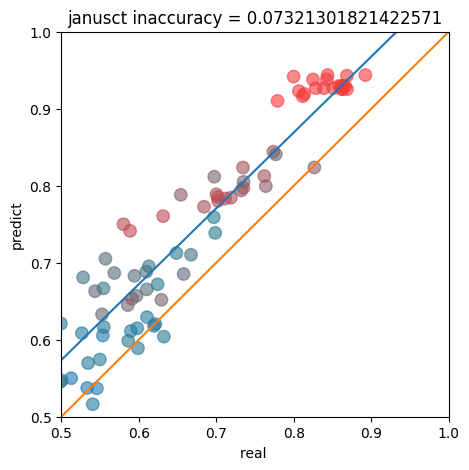

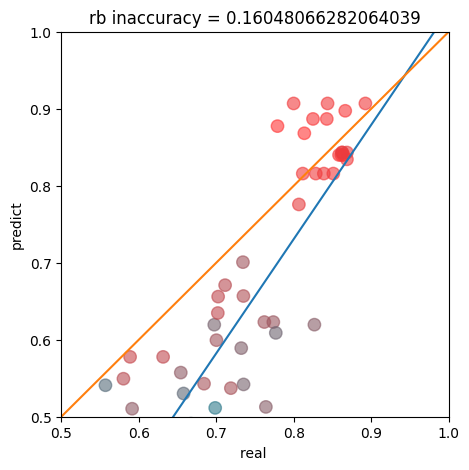

In [9]:
from janusq.tools.plot import plot_scatter

durations = np.array([cir.duration for cir in benchmarking_circuits])

fig_quct, axes_quct = plot_scatter(benchmarking_fidelities, janusct_fidelities, durations, title = f"janusct inaccuracy = {np.abs(benchmarking_fidelities - janusct_fidelities).mean()}")
fig_rb, axes_rb = plot_scatter(benchmarking_fidelities, rb_fidelities, durations, title = f"rb inaccuracy = {np.abs(benchmarking_fidelities - rb_fidelities).mean()}")
